In [1]:
#!pip install -r requirements.txt

In [2]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,6]

## Imports

In [3]:
DATA_ROOT = os.path.abspath('../../../../datasets/thick_smears_150')
GT_ROOT  = os.path.join(DATA_ROOT,'GT_updated')
all_files = glob.glob(os.path.join(GT_ROOT,'*','*.txt'))
#all_images = glob.glob(os.path.join(DATA_ROOT,'*','*.jpg'))
all_images = [p.replace('/GT_updated','').replace('.txt','.jpg') for p in all_files]

## Load mask info

In [4]:
def read_info(path):
    # Read df from text file (minus header)
    columns = ['id', 'classification', 'comments', 'circle_or_point', 'circ_point_num',
               'x_centre', 'y_centre', 'x_point_circle', 'y_point_circle']
    temp = pd.read_csv(path, names = columns, skiprows=1)
    
    # Assign a unique path
    p = Path(path)   # Better to use this library than DIY
    temp.insert(loc = 1,    # Insert in position 1 (just after column "id")
                column = 'patient_id',
                value = p.parent.name
               )
    temp.insert(loc = 2,    # Insert in position 2
                column = 'timestamp',
                value = p.name.replace('.txt','')
               )
    
    # Parse header to retrieve metadata
    with open(path) as file:
        o,h,w = file.readline().strip().split(',')

    # Add metadata
    temp['n_objects'] = int(o)
    temp['height'], temp['width'] = int(h),int(w)
    
    return temp

df = pd.concat(map(read_info,all_files))  # Do a map to avoid creating the list of df explicitely

In [5]:
def calc_radius(x_diff,y_diff):
    return np.sqrt(np.power(x_diff,2) + np.power(y_diff,2))

# Calculate radius
df['radius'] = calc_radius(df['x_centre'] - df['x_point_circle'],df['y_centre'] - df['y_point_circle'])      

# Cast all numerical columns to int, this will round 
df[df.select_dtypes('number').columns] = df.select_dtypes('number').fillna(0).astype('int')
df.head()

,id,patient_id,timestamp,classification,comments,circle_or_point,circ_point_num,x_centre,y_centre,x_point_circle,y_point_circle,n_objects,height,width,radius
0,1-2,TF60_15_18,20170816_093951,Parasite,No_Comment,Circle,2,2518,1822,2521,1839,24,4032,3024,17
1,1-3,TF60_15_18,20170816_093951,Parasite,No_Comment,Circle,2,1927,1693,1927,1713,24,4032,3024,19
2,1-10,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,1132,499,0,0,24,4032,3024,0
3,1-11,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,1319,954,0,0,24,4032,3024,0
4,1-12,TF60_15_18,20170816_093951,White_Blood_Cell,No_Comment,Point,1,1290,1220,0,0,24,4032,3024,0


In [6]:
print(
    df.height.value_counts(),
    df.width.value_counts(),
    sep='\n'
)

4032    120441
Name: height, dtype: int64
3024    120441
Name: width, dtype: int64


All images have the exact same size, we could have not included the image size in the df

### Create mask from center and radius

In [38]:
# Grab an example
temp = df[df.circle_or_point=='Circle'].to_dict()
k = 3

x = temp['x_centre'][k]
y = temp['y_centre'][k]
r = temp['radius'][k]
p = temp['patient_id'][k]
t = temp['timestamp'][k]

x,y,r,p,t

(2073, 2240, 18, 'TF84_BD2_96', '20170820_113138')

In [39]:
#Generate the path of the image to load
img_path = os.path.join(DATA_ROOT,p,t+'.jpg')
img_path

'/Users/Alex/Google Drive/AI4good/datasets/thick_smears_150/TF84_BD2_96/20170820_113138.jpg'

(4032, 3024, 3)


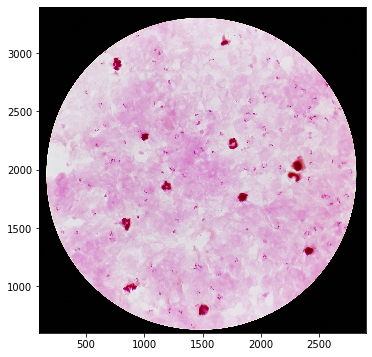

In [40]:
img = cv2.imread(img_path) 
print(img.shape)

plt.imshow(img);
plt.xlim(100,2900);
plt.ylim(600,3400);

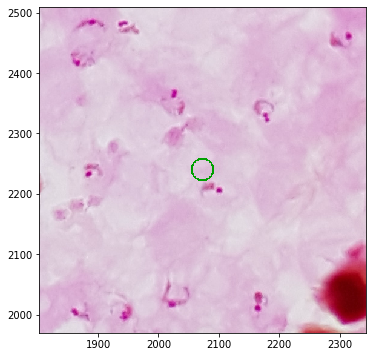

In [42]:
#background = np.zeros((4032,3024), np.uint8)

# Add the outline
new_img = cv2.circle(img,
                     center = (x,y),  # Because of opencv standard, might be (y,x) instead ????
                     radius = r,
                     color = (0,160,0), # Darkish green
                     thickness = 2
                    )

# Add the filling
'''
new_img = cv2.circle(new_img,
                          center = (x,y),
                           radius = r,
                           color = [0,255,0], # Light green
                           thickness = cv2.FILLED  # Will draw a filled circle
                          )
'''

zoom = 15*r
plt.imshow(new_img);
plt.xlim(x-zoom,x+zoom)
plt.ylim(y-zoom,y+zoom);

**Why is there a misalignement????**